In [98]:
#import libraries
import os, sys
import json
import pandas as pd
import geopandas as gpd
import numpy as np
from numpy import int64
import requests, io
import urllib.request
import folium
from folium import plugins
import fiona
import branca
from branca.colormap import linear
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import mapclassify.classifiers as classifiers
from IPython.display import IFrame
import keplergl
from matplotlib import cm

In [99]:
url = 'https://www.worldometers.info/coronavirus/#countries'
response = requests.get(url)

In [100]:
data = response.content.decode('utf-8')


In [101]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
    
class HTMLTableParser:
       
        def parse_url(self, url):
            response = requests.get(url)
            soup = BeautifulSoup(response.text, 'lxml')
            return [(table['id'],self.parse_html_table(table))\
                    for table in soup.find_all('table')]  
    
        def parse_html_table(self, table):
            n_columns = 0
            n_rows=0
            column_names = []
    
            # Find number of rows and columns
            # we also find the column titles if we can
            for row in table.find_all('tr'):
                
                # Determine the number of rows in the table
                td_tags = row.find_all('td')
                if len(td_tags) > 0:
                    n_rows+=1
                    if n_columns == 0:
                        # Set the number of columns for our table
                        n_columns = len(td_tags)
                        
                # Handle column names if we find them
                th_tags = row.find_all('th') 
                if len(th_tags) > 0 and len(column_names) == 0:
                    for th in th_tags:
                        column_names.append(th.get_text())
    
            # Safeguard on Column Titles
            if len(column_names) > 0 and len(column_names) != n_columns:
                raise Exception("Column titles do not match the number of columns")
    
            columns = column_names if len(column_names) > 0 else range(0,n_columns)
            df = pd.DataFrame(columns = columns,
                              index= range(0,n_rows))
            row_marker = 0
            for row in table.find_all('tr'):
                column_marker = 0
                columns = row.find_all('td')
                for column in columns:
                    df.iat[row_marker,column_marker] = column.get_text()
                    column_marker += 1
                if len(columns) > 0:
                    row_marker += 1
                    
            # Convert to float if possible
            for col in df:
                try:
                    df[col] = df[col].astype(float)
                except ValueError:
                    pass
            
            return df


In [102]:
hp = HTMLTableParser()
table = hp.parse_url(url)[0][1] # Grabbing the table from the tuple
table.head(10)

#      Country,Other   TotalCases NewCases  \
0     \nNorth America\n  126,964,303            
1              \nAsia\n  218,124,117       +5   
2            \nEurope\n  249,634,961            
3     \nSouth America\n   68,817,507            
4           \nOceania\n   14,521,437            
5            \nAfrica\n   12,829,487            
6                  \n\n          721            
7                 World  690,892,533       +5   
8  1                USA  107,298,305            
9  2              India   44,994,032            

                                 TotalDeaths NewDeaths TotalRecovered  \
0                                  1,637,117              122,937,829   
1                                  1,547,512              201,803,523   
2                                  2,065,247              245,722,559   
3                                  1,357,438               66,484,101   
4                                     28,978               14,355,427   
5                                    258,804               12,087,486   
6                                         15                      706   
7                                  6,895,111         0    663,391,631   
8  1,168,045                                              105,442,297   
9    531,903                                               44,460,523   

  NewRecovered ActiveCases Serious,Critical  ...     TotalTests  \
0                2,389,357            5,953  ...                  
1      +18,239  14,773,082           15,120  ...                  
2       +4,003   1,847,155            5,531  ...                  
3                  975,968           10,100  ...                  
4                  137,032               86  ...                  
5          +12     483,197              547  ...                  
6                        0                0  ...                  
7      +22,198  20,605,791           37,337  ...                  
8                  687,963              787  ...  1,180,737,177   
9                    1,606              N/A  ...    930,797,975   

  Tests/\n1M pop\n      Population          Continent 1 Caseevery X ppl  \
0                                       North America                \n   
1                                                Asia                \n   
2                                              Europe                \n   
3                                       South America                \n   
4                                   Australia/Oceania                \n   
5                                              Africa                \n   
6                                                                    \n   
7                                                 All                \n   
8        3,526,639    334,805,269       North America                 3   
9          661,721  1,406,631,776                Asia                31   

  1 Deathevery X ppl 1 Testevery X ppl New Cases/1M pop New Deaths/1M pop  \
0                                                                           
1                                                                           
2                                                                           
3                                                                           
4                                                                           
5                                                                           
6                                                                           
7                                                                           
8                287                 0                                      
9              2,645                 2                                      

  Active Cases/1M pop  
0                      
1                      
2                      
3                      
4                      
5                      
6                      
7                      
8               2,055  
9      

In [103]:
#check bottom rows
table.tail(10)

# Country,Other   TotalCases NewCases  \
237  230       Tokelau            5            
238  231         China      503,302            
239             Total:  126,964,303            
240             Total:  218,124,117       +5   
241             Total:  249,634,961            
242             Total:   68,817,507            
243             Total:   14,521,437            
244             Total:   12,829,487            
245             Total:          721            
246             Total:  690,892,533       +5   

                               TotalDeaths NewDeaths TotalRecovered  \
237                                                                   
238  5,272                                                  379,053   
239                              1,637,117              122,937,829   
240                              1,547,512              201,803,523   
241                              2,065,247              245,722,559   
242                              1,357,438               66,484,101   
243                                 28,978               14,355,427   
244                                258,804               12,087,486   
245                                     15                      706   
246                              6,895,111         0    663,391,631   

    NewRecovered ActiveCases Serious,Critical  ...   TotalTests  \
237                        5                   ...                
238                  118,977              N/A  ...  160,000,000   
239                2,389,357            5,953  ...                
240               14,773,082           15,120  ...                
241                1,847,155            5,531  ...                
242                  975,968           10,100  ...                
243                  137,032               86  ...                
244                  483,197              547  ...                
245                        0                0  ...                
246      +22,198  20,605,791           37,337  ...                

    Tests/\n1M pop\n                                     Population  \
237                                                          1,378    
238          110,461  1,448,471,400                                   
239                                                                   
240                                                                   
241                                                                   
242                                                                   
243                                                                   
244                                                                   
245                                                                   
246                                                                   

             Continent 1 Caseevery X ppl 1 Deathevery X ppl 1 Testevery X ppl  \
237  Australia/Oceania               276                                        
238               Asia             2,878            274,748                 9   
239      North America                                                          
240               Asia                                                          
241             Europe                                                          
242      South America                                                          
243  Australia/Oceania                                                          
244             Africa                                                          
245                                                                             
246                All                \n                                        

    New Cases/1M pop New Deaths/1M pop Active Cases/1M pop  
237                                                  3,628  
238                                                     82  
239                                                         
240                                     

In [104]:
#Drop top buttom unwanted rows
df= table.drop(table.index[[0,1,2,3,4,5,6,7]]).reset_index(drop=True)
#drop tail unwanted rows
df.drop(df.tail(8).index,inplace=True)
#drop new line '\n' charachter 
df.replace(['\n'], '', regex=True, inplace=True)
df.replace([','], '', regex=True, inplace=True)

In [105]:
# drop unwanted drop unwanted special characters using a loop
# drop unwanted drop unwanted special characters using a loop
for col in df.columns[1:11]:
    df[col] = df[col].str.replace("+", "").str.replace(",", "").str.replace("N/A", "").str.replace(" ", "")


C:\Users\Seth\AppData\Local\Temp\ipykernel_7360\2557810530.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace("+", "").str.replace(",", "").str.replace("N/A", "").str.replace(" ", "")


In [106]:
df1 = df.rename(columns={'Country,Other': 'CNTRY_NAME', 'Serious,Critical': 'Serious_Critical', 'Tot Cases/1M pop': 'Tot_Cases_1M_pop', 'Deaths/1M pop': 'Deaths_1M_pop', 'Tests/\n1M pop\n': 'Tests_1M_pop'})

In [107]:
#convert object columns in dataframe to numeric
df1.fillna(0, inplace=True)
df1.replace(np.nan, 0, inplace=True)
df1.replace(np.inf, 0, inplace=True)
for col in df1.columns[1:11]: 
    df1[col] = pd.to_numeric(df1[col], errors='ignore')

In [108]:
#convert float columns in data frame to integer

df1.fillna(0, inplace=True)
df1.replace(np.nan, 0, inplace=True)
df1.replace(np.inf, 0, inplace=True)

for col in df1.columns[1:11]:
    try:
        df1[col] = df1[col].astype(int)
    except ValueError:
        print(f"Unable to convert column '{col}' to integer type.")

Unable to convert column 'CNTRY_NAME' to integer type.


In [109]:
df1.sort_values(by=['TotalCases'], inplace=True, ascending=False)
df1.head(10)


# CNTRY_NAME  TotalCases  NewCases  TotalDeaths  NewDeaths  \
0   1        USA   107298305         0      1168045          0   
1   2      India    44994032         0       531903          0   
2   3     France    40135200         0       167642          0   
3   4    Germany    38428685         0       174352          0   
4   5     Brazil    37671420         0       703964          0   
5   6      Japan    33803572         0        74694          0   
6   7    S.Korea    32131606         0        35017          0   
7   8      Italy    25893101         0       190782          0   
8   9         UK    24618436         0       226278          0   
9  10     Russia    22953409         0       399436          0   

   TotalRecovered  NewRecovered  ActiveCases  Serious_Critical  ...  \
0       105442297             0       687963               787  ...   
1        44460523             0         1606                 0  ...   
2        39937566             0        29992               869  ...   
3        38240600             0        13733                 0  ...   
4        36249161             0       718295                 0  ...   
5               0             0            0                83  ...   
6        31848662         17772       247927               117  ...   
7        25587953             0       114366                54  ...   
8        24392158             0            0                 0  ...   
9        22395145             0       158828                 0  ...   

   TotalTests Tests_1M_pop   Population      Continent 1 Caseevery X ppl  \
0  1180737177      3526639   334805269   North America                 3   
1   930797975       661721  1406631776            Asia                31   
2   271490188      4139547    65584518          Europe                 2   
3   122332384      1458359    83883596          Europe                 2   
4    63776166       296146   215353593   South America                 6   
5   100414883       799578   125584838            Asia                 4   
6    15804065       307892    51329899            Asia                 2   
7   273454631      4537704    60262770          Europe                 2   
8   522526476      7628357    68497907          Europe                 3   
9   273400000      1875095   145805947          Europe                 6   

  1 Deathevery X ppl 1 Testevery X ppl New Cases/1M pop New Deaths/1M pop  \
0                287                 0                                      
1               2645                 2                                      
2                391                 0                                      
3                481                 1                                      
4                306                 3                                      
5               1681                 1                                      
6               1466                 3                                      
7                316                 0                                      
8                303                 0                                      
9                365                 1                                      

  Active Cases/1M pop  
0                2055  
1                   1  
2                 457  
3                 164  
4                3335  
5               95582  
6                4830  
7                1898  
8                      
9                1089  

[10 rows x 22 columns]

C:\Users\Seth\anaconda3\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

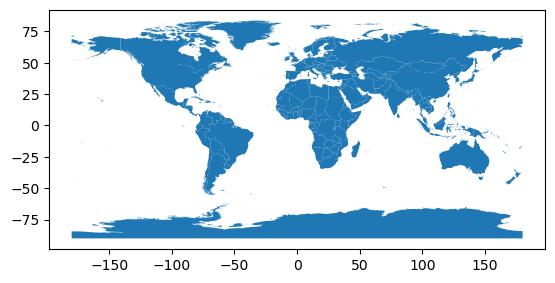

In [110]:
# get country data
url = "https://opendata.arcgis.com/datasets/a21fdb46d23e4ef896f31475217cbb08_1.geojson"
world = gpd.read_file(url)
world.plot()

In [111]:
world.CNTRY_NAME = world.CNTRY_NAME.replace('United States', 'USA').replace('United Kingdom', 'UK')


In [112]:
corona = world.merge(df1, on='CNTRY_NAME', how='left')
corona.dtypes

OBJECTID                  int64
CNTRY_NAME               object
geometry               geometry
#                        object
TotalCases              float64
NewCases                float64
TotalDeaths             float64
NewDeaths               float64
TotalRecovered          float64
NewRecovered            float64
ActiveCases             float64
Serious_Critical        float64
Tot Cases/1M pop        float64
Deaths_1M_pop            object
TotalTests               object
Tests_1M_pop             object
Population               object
Continent                object
1 Caseevery X ppl        object
1 Deathevery X ppl       object
1 Testevery X ppl        object
New Cases/1M pop         object
New Deaths/1M pop        object
Active Cases/1M pop      object
dtype: object

In [113]:
corona.fillna(0, inplace=True)
corona.replace(np.nan, 0, inplace=True)
corona.replace(np.inf, 0, inplace=True)
for col in corona.columns[3:10]: 
    corona[col]=corona[col].astype(int)
corona.dtypes

OBJECTID                  int64
CNTRY_NAME               object
geometry               geometry
#                         int32
TotalCases                int32
NewCases                  int32
TotalDeaths               int32
NewDeaths                 int32
TotalRecovered            int32
NewRecovered              int32
ActiveCases             float64
Serious_Critical        float64
Tot Cases/1M pop        float64
Deaths_1M_pop            object
TotalTests               object
Tests_1M_pop             object
Population               object
Continent                object
1 Caseevery X ppl        object
1 Deathevery X ppl       object
1 Testevery X ppl        object
New Cases/1M pop         object
New Deaths/1M pop        object
Active Cases/1M pop      object
dtype: object

In [114]:
df_world = pd.merge(df1, world, on='CNTRY_NAME')
crs = {'init': 'epsg:4326'}
corona_gpd = gpd.GeoDataFrame(df_world, crs=crs, geometry='geometry')
corona_gpd.head(5)

C:\Users\Seth\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


# CNTRY_NAME  TotalCases  NewCases  TotalDeaths  NewDeaths  TotalRecovered  \
0  1        USA   107298305         0      1168045          0       105442297   
1  2      India    44994032         0       531903          0        44460523   
2  3     France    40135200         0       167642          0        39937566   
3  4    Germany    38428685         0       174352          0        38240600   
4  5     Brazil    37671420         0       703964          0        36249161   

   NewRecovered  ActiveCases  Serious_Critical  ...   Population  \
0             0       687963               787  ...   334805269    
1             0         1606                 0  ...  1406631776    
2             0        29992               869  ...    65584518    
3             0        13733                 0  ...    83883596    
4             0       718295                 0  ...   215353593    

       Continent 1 Caseevery X ppl 1 Deathevery X ppl 1 Testevery X ppl  \
0  North America                 3                287                 0   
1           Asia                31               2645                 2   
2         Europe                 2                391                 0   
3         Europe                 2                481                 1   
4  South America                 6                306                 3   

  New Cases/1M pop New Deaths/1M pop Active Cases/1M pop OBJECTID  \
0                                                   2055      233   
1                                                      1      106   
2                                                    457       78   
3                                                    164       88   
4                                                   3335       30   

                                            geometry  
0  MULTIPOLYGON (((-134.97501 58.64583, -134.9213...  
1  MULTIPOLYGON (((92.26860 23.71944, 92.20305 23...  
2  MULTIPOLYGON (((6.24375 46.31551, 6.23000 46.3...  
3  MULTIPOLYGON (((7.36901 49.16878, 7.36403 49.1...  
4  MULTIPOLYGON (((-70.62862 -9.94849, -70.62889 ...  

[5 rows x 24 columns]

C:\Users\Seth\anaconda3\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


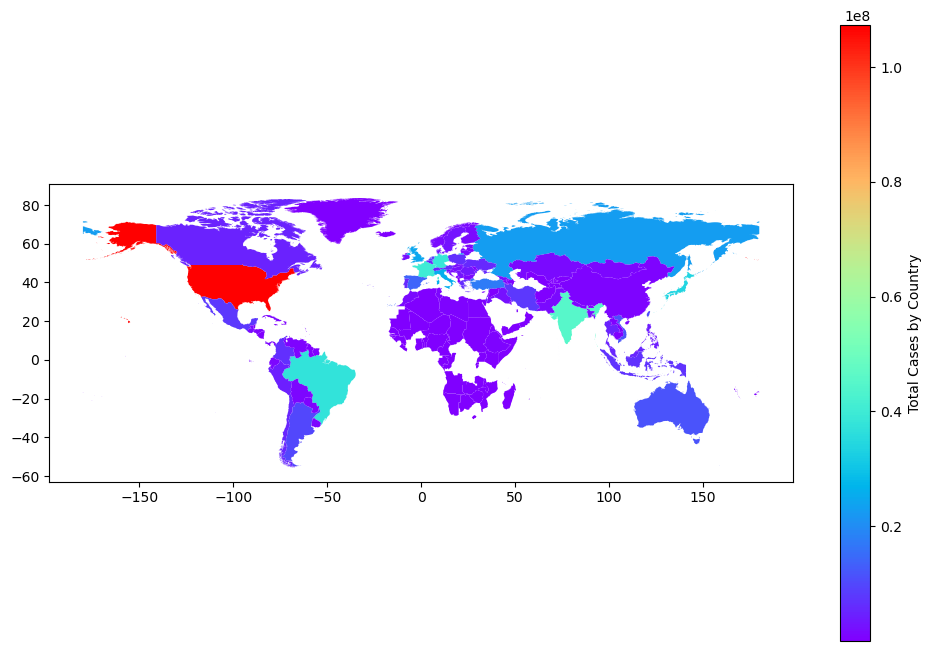

In [115]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
corona_gpd.plot(column='TotalCases', cmap='rainbow', ax=ax, legend=True, 
                legend_kwds={'label': 'Total Cases by Country'})

plt.show()

C:\Users\Seth\anaconda3\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


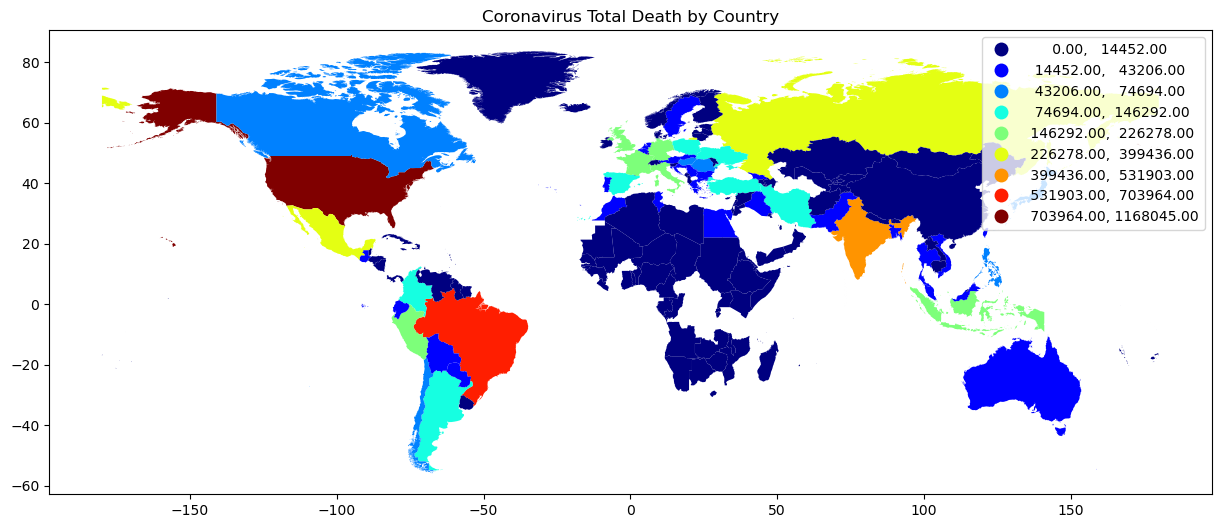

In [116]:
ax = corona_gpd.plot(figsize=(15, 15), column='TotalDeaths', cmap='jet', scheme='fisher_jenks', k=9, alpha=1, legend=True, markersize=0.5)
plt.title('Coronavirus Total Death by Country')
plt.show()

In [117]:
import hvplot.pandas
corona_gpd.hvplot(c='TotalDeaths', cmap='rainbow',
   width=800,height=450,
   title='TotalDeaths by Country') 

:Polygons   [x,y]   (TotalDeaths)

In [119]:
# Read the COVID-19 data from the provided URL
covid = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', delimiter=',')

# Rename the 'location' column to 'COUNTRY'
covid1 = covid.rename(columns={'location': 'COUNTRY'})

# Assuming 'world' is another GeoDataFrame containing world data

# Merge the 'world' GeoDataFrame with the 'covid1' DataFrame
covid_gdp = pd.merge(world, covid1)

# Set the coordinate reference system (CRS) to 'epsg:4326'
crs = {'init': 'epsg:4326'}

# Convert the DataFrame to a GeoDataFrame with the specified CRS and geometry column
covid_gdp = gpd.GeoDataFrame(covid_gdp, crs=crs, geometry='geometry')

# Plot the COVID-19 total deaths by country and date using hvPlot
covid_gdp.hvplot(
    c="total_deaths",
    cmap="YlOrRd",
    hover_cols=['COUNTRY', 'total_deaths'],
    hover_fill_color="grey",
    line_width=2,
    width=800,
    height=450,
    groupby='date',
    title="Covid-19 Total Deaths by Country/Date"
)


MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [120]:

m = folium.Map(location=[43.6532, -79.3832])#Toronto
m

In [121]:
folium.Map(location=[43.6532, -79.3832],
 zoom_start=12,
 tiles='https://services.arcgisonline.com/arcgis/rest/services/World_Topo_Map/MapServer/WMTS/tile/1.0.0/World_Topo_Map/default/default028mm/{z}/{y}/{x}.png',
 attr='Ablajan or anything else...')

In [149]:
#load gdf to map
gjson = corona_gpd.to_crs(epsg='4326').to_json()
#embed map 
def embed_map(m):
   from IPython.display import IFrame
   m.save('index.html')
   return IFrame('index.html', width='100%', height='750px')
map = folium.Map([43.783333, -79.866667], zoom_start=2)
country = folium.features.GeoJson(gjson)
map.add_child(country)
embed_map(map)

In [148]:
def embed_map(m):
    from IPython.display import IFrame
    m.save('index.html')
    return IFrame('index.html', width='100%', height='500px')

# Add basemap
map = folium.Map([0, 0], zoom_start=2, tiles='https://services.arcgisonline.com/arcgis/rest/services/World_Topo_Map/MapServer/WMTS/tile/1.0.0/World_Topo_Map/default/default028mm/{z}/{y}/{x}.png',
 attr='Esri ..., Ablajan or anything else...')

gjson = corona_gpd.to_crs(epsg='4326').to_json()
df2 = pd.DataFrame({'CNTRY_NAME': ['Country1', 'Country2', 'Country3'],
                    'TotalDeaths': [100, 200, 300]})
df3 = df2.set_index('CNTRY_NAME')['TotalDeaths'].dropna()

colorscale = branca.colormap.linear.YlOrRd_09.scale(df2.TotalDeaths.min(), df2.TotalDeaths.max())

def style_function(feature):
    TotalDeaths = df3.get(int(feature['id'][-1:]), None)
    return {
        'fillOpacity': 1,
        'weight': 1,
        'fillColor': '#000000' if TotalDeaths is None else colorscale(TotalDeaths)
    }

colorscale.add_to(map)
colorscale.caption = 'Total Deaths by Country'


map.add_child(country)
embed_map(map)

In [130]:
covid= pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv') 
# filter certain country
covid_ca =covid[covid.location =='Canada'].sort_values(['total_cases'],ascending=False) 
covid_ca.head(10)

iso_code      continent location        date  total_cases  new_cases  \
49403      CAN  North America   Canada  2023-06-21    4686867.0        NaN   
49402      CAN  North America   Canada  2023-06-20    4686867.0        NaN   
49401      CAN  North America   Canada  2023-06-19    4686867.0        NaN   
49400      CAN  North America   Canada  2023-06-18    4686867.0     2089.0   
49399      CAN  North America   Canada  2023-06-17    4684778.0        0.0   
49398      CAN  North America   Canada  2023-06-16    4684778.0        0.0   
49397      CAN  North America   Canada  2023-06-15    4684778.0        0.0   
49396      CAN  North America   Canada  2023-06-14    4684778.0        0.0   
49395      CAN  North America   Canada  2023-06-13    4684778.0        0.0   
49394      CAN  North America   Canada  2023-06-12    4684778.0        0.0   

       new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
49403                 NaN       52804.0         NaN                  NaN  ...   
49402                 NaN       52804.0         NaN                  NaN  ...   
49401                 NaN       52804.0         NaN                  NaN  ...   
49400             298.429       52804.0        37.0                5.286  ...   
49399             420.286       52767.0         0.0                8.143  ...   
49398             420.286       52767.0         0.0                8.143  ...   
49397             420.286       52767.0         0.0                8.143  ...   
49396             420.286       52767.0         0.0                8.143  ...   
49395             420.286       52767.0         0.0                8.143  ...   
49394             420.286       52767.0         0.0                8.143  ...   

       male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
49403          16.6                     NaN                         2.5   
49402          16.6                     NaN                         2.5   
49401          16.6                     NaN                         2.5   
49400          16.6                     NaN                         2.5   
49399          16.6                     NaN                         2.5   
49398          16.6                     NaN                         2.5   
49397          16.6                     NaN                         2.5   
49396          16.6                     NaN                         2.5   
49395          16.6                     NaN                         2.5   
49394          16.6                     NaN                         2.5   

       life_expectancy  human_development_index  population  \
49403            82.43                    0.929  38454328.0   
49402            82.43                    0.929  38454328.0   
49401            82.43                    0.929  38454328.0   
49400            82.43                    0.929  38454328.0   
49399            82.43                    0.929  38454328.0   
49398            82.43                    0.929  38454328.0   
49397            82.43                    0.929  38454328.0   
49396            82.43                    0.929  38454328.0   
49395            82.43                    0.929  38454328.0   
49394            82.43                    0.929  38454328.0   

       excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
49403                                   NaN                          NaN   
49402                                   NaN                          NaN   
49401                                   NaN                          NaN   
49400                                   NaN                          NaN   
49399                                   NaN                          NaN   
49398                                   NaN                          NaN   
49397                                   NaN                          NaN   
49396                                   NaN                          NaN   
49395                                   NaN        

In [134]:
# keep wanted columns only
covid_gdp = covid_gdp[['COUNTRY', 'TotalCases', 'TotalDeath','NewDeaths', 'TotalRecovered', 'ActiveCases','Serious_Critical', 'geometry' ]]
corona = keplergl.KeplerGl(height=500)
corona.add_data(data=covid_gdp, name='Covid_19')
corona.save_to_html(file_name='.\covid19_map.html')
corona

NameError: name 'covid_gdp' is not defined